## Alternative Model (Training)

I've found WaveRNN quite slow to train so here's an alternative that utilises the optimised rnn kernels in Pytorch. The model below is much much faster to train, it will converge in 48hrs when training on 22.5kHz samples (or 24hrs using 16kHz samples) on a single GTX1080. It also works quite well with predicted GTA features. 

The model is simply two residual GRUs in sequence and then three dense layers with a 512 softmax output. This is supplemented with an upsampling network.

Since the Pytorch rnn kernels are 'closed', the options for conditioning sites are greatly reduced. Here's the strategy I went with given that restriction:  

1 - Upsampling: Nearest neighbour upsampling followed by 2d convolutions with 'horizontal' kernels to interpolate. Split up into two or three layers depending on the stft hop length.

2 - A 1d resnet with a 5 wide conv input and 1x1 res blocks. Not sure if this is necessary, but the thinking behind it is: the upsampled features give a local view of the conditioning - why not supplement that with a much wider view of conditioning features, including a peek at the future. One thing to note is that the resnet is computed only once and in parallel, so it shouldn't slow down training/generation much. 

Train this model to ~500k steps for 8/9bit linear samples or ~1M steps for 10bit linear or 9+bit mu_law. 

In [1]:
%matplotlib inline
import math, pickle, os
import numpy as np
import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from utils.display import *
from utils.dsp import *
import python_speech_features as psf
from tqdm import tqdm

In [2]:
bits = 9
pad = 2
seq_len = hop_length * 9
#9 so that the kernel outputs the right size
seq_len
#seq_len = coef * mel_win
#coef = total_scale

1053

In [3]:
notebook_name = 'nb4'

In [4]:
%mkdir -p 'model_checkpoints/'

Sintassi del comando errata.


In [5]:
MODEL_PATH = f'model_checkpoints/{notebook_name}.pyt'
DATA_PATH = f'data/'
STEP_PATH = f'model_checkpoints/{notebook_name}_step.npy'
GEN_PATH = f'model_outputs/{notebook_name}/'
%mkdir -p $GEN_PATH

Sintassi del comando errata.


## Dataset

In [6]:
with open(f'{DATA_PATH}dataset_ids.pkl', 'rb') as f:
    dataset_ids = pickle.load(f)

In [7]:
test_ids = dataset_ids[:-2048]
dataset_ids = dataset_ids[-2048:]

In [8]:
class AudiobookDataset(Dataset):
    def __init__(self, ids, path):
        self.path = path
        self.metadata = ids
        
    def __getitem__(self, index):
        file = self.metadata[index]
        m = np.load(f'{self.path}mel/{file}.npy')
        x = np.load(f'{self.path}quant/{file}.npy')
        pitch = np.load(f'{self.path}pitch/{file}.npy')
        return m, x, pitch

    def __len__(self):
        return len(self.metadata)

In [9]:
def collate(batch) :
    #mel_win = seq_len // hop_length + 2 * pad
    s=0
    for x in batch:
        s+=x[0].shape[-1]/len(x[1])
    proportional_coeff = s/len(batch)
    
    mel_win = round(seq_len * proportional_coeff)
    #print(mel_win)
    max_offsets = [x[1].shape[-1] - (seq_len + 2 * pad) for x in batch]
    sig_offsets = [np.random.randint(0, offset) for offset in max_offsets]
    mel_offsets = [round(offset*proportional_coeff) for i,offset in enumerate(sig_offsets)]

    mels = [x[0][:, mel_offsets[i]:mel_offsets[i] + mel_win] \
            for i, x in enumerate(batch)]
    
    coarse = [x[1][sig_offsets[i]:sig_offsets[i] + seq_len + 1] \
              for i, x in enumerate(batch)]
    
    pitch = [x[2][sig_offsets[i]:sig_offsets[i] + seq_len + 1] \
              for i, x in enumerate(batch)]
    
    mels = np.stack(mels).astype(np.float32)
    coarse = np.stack(coarse).astype(np.int64)
    pitch = np.stack(pitch).astype(np.float32)
   
    
    mels = torch.FloatTensor(mels)
    coarse = torch.LongTensor(coarse)
    pitch = torch.FloatTensor(pitch)
    
    x_input = 2 * coarse[:, :seq_len].float() / (2**bits - 1.) - 1.
    
    y_coarse = coarse[:, 1:]
    
    return x_input, mels, pitch[:, :seq_len], y_coarse

In [10]:
dataset = AudiobookDataset(dataset_ids, DATA_PATH)

In [11]:
data_loader = DataLoader(dataset, collate_fn=collate, batch_size=32, 
                         num_workers=0, shuffle=True)

In [12]:
x, m, p, y = next(iter(data_loader))
x.shape, m.shape, p.shape, y.shape

(torch.Size([32, 1053]),
 torch.Size([32, 13, 9]),
 torch.Size([32, 1053]),
 torch.Size([32, 1053]))

## Define Model Classes

In [13]:
class ResBlock(nn.Module) :
    def __init__(self, dims) :
        super().__init__()
        self.conv1 = nn.Conv1d(dims, dims, kernel_size=1, bias=False)
        self.conv2 = nn.Conv1d(dims, dims, kernel_size=1, bias=False)
        self.batch_norm1 = nn.BatchNorm1d(dims)
        self.batch_norm2 = nn.BatchNorm1d(dims)
        
    def forward(self, x) :
        residual = x
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.batch_norm2(x)
        return x + residual

In [14]:
class MelResNet(nn.Module) :
    def __init__(self, res_blocks, in_dims, compute_dims, res_out_dims) :
        super().__init__()
        #k_size = pad * 2 + 1
        k_size = 1
        self.conv_in = nn.Conv1d(in_dims, compute_dims, kernel_size=k_size, bias=False)
        self.batch_norm = nn.BatchNorm1d(compute_dims)
        self.layers = nn.ModuleList()
        for i in range(res_blocks) :
            self.layers.append(ResBlock(compute_dims))
        self.conv_out = nn.Conv1d(compute_dims, res_out_dims, kernel_size=1)
        
    def forward(self, x) :
        #x: (32, 13, 9) = (batch_size, number_mel_coeff, mel_seq_len)
        x = self.conv_in(x)
        #x: (32, 128, 5) = (batch_size, compute_dims, kernel_size)
        x = self.batch_norm(x)
        #x: (32, 128, 5)
        x = F.relu(x)
        for f in self.layers : x = f(x)
        #x: (32, 128, 5)
        x = self.conv_out(x)
        #x: (32, 128, 5)
        return x        

In [15]:
class Stretch2d(nn.Module) :
    def __init__(self, x_scale, y_scale) :
        super().__init__()
        self.x_scale = x_scale
        self.y_scale = y_scale
        
    def forward(self, x) :
        b, c, h, w = x.size()
        x = x.unsqueeze(-1).unsqueeze(3)
        x = x.repeat(1, 1, 1, self.y_scale, 1, self.x_scale)
        return x.view(b, c, h * self.y_scale, w * self.x_scale)

In [16]:
class UpsampleNetwork(nn.Module) :
    def __init__(self, feat_dims, upsample_scales, compute_dims, 
                 res_blocks, res_out_dims, pad) :
        """
        upsample_scales = (5,5,11)
        """
        super().__init__()
        total_scale = np.cumproduct(upsample_scales)[-1]
        self.indent = pad * total_scale
        self.resnet = MelResNet(res_blocks, feat_dims, compute_dims, res_out_dims)
        self.resnet_stretch = Stretch2d(total_scale, 1)
        self.up_layers = nn.ModuleList()
        for scale in upsample_scales :
            k_size = (1, scale * 2 + 1)
            padding = (0, scale)
            stretch = Stretch2d(scale, 1)
            conv = nn.Conv2d(1, 1, kernel_size=k_size, padding=padding, bias=False)
            conv.weight.data.fill_(1. / k_size[1])
            self.up_layers.append(stretch)
            self.up_layers.append(conv)
    
    def forward(self, m) :
        #m: (32, 13, 5) = (batch_size, number_mel_coeff, mel_seq_len)
        aux = self.resnet(m).unsqueeze(1)
        #kernel_size = pad*2 + 1
        #aux: (32, 1, 128, 5) = (batch_size, 1, compute_dims, kernel_size)
        aux = self.resnet_stretch(aux)
        #aux: (32, 1, 128, 585) = (batch_size, 1, compute_dims, total_scale*kernel_size)
        aux = aux.squeeze(1)
        #aux: (32, 128, 1375) = (batch_size, compute_dims, total_scale*kernel_size)
        m = m.unsqueeze(1)
        #m: (32, 1, 13, 9) = (batch_size, 1, number_mel_coeff, mel_seq_len)
        for f in self.up_layers : 
            """
            1 stretch = Stretch2D(scale,1)
            1 conv = Conv2D(1,1, kernel_size = (1,2*scale+1), padding= (0,scale)) (doesn't change the size)
            """
            m = f(m)
            #m: (32, 1, 13, 45) = (batch_size, 1, number_mel_coeff, mel_seq_len*5)
            #m: (32, 1, 13, 225) = (batch_size, 1, number_mel_coeff, mel_seq_len*5*5)
            #m: (32, 1, 13, 2475) = (batch_size, 1, number_mel_coeff, mel_seq_len*5*5*11)
            
        #m: (32, 1, 13, 2475) = (batch_size, 1, number_mel_coeff, mel_seq_len*total_scale)
        #m = m.squeeze(1)[:, :, self.indent:-self.indent]
        m=m.squeeze(1)
        ##m: (32, 13, 1375) = (batch_size, number_mel_coeff, (mel_seq_len-2*pad)*total_scale)
        #Where total_scale is the the product of the upsample_factors 
        return m.transpose(1, 2), aux.transpose(1, 2)

In [17]:
class Model(nn.Module) :
    def __init__(self, rnn_dims, fc_dims, bits, pad, upsample_factors,
                 feat_dims, compute_dims, res_out_dims, res_blocks,
                 hop_length, sample_rate):
        super().__init__()
        self.pad = pad
        self.n_classes = 2**bits
        self.rnn_dims = rnn_dims
        self.aux_dims = res_out_dims // 4
        self.hop_length = hop_length
        self.sample_rate = sample_rate
        self.upsample = UpsampleNetwork(feat_dims, upsample_factors, compute_dims, 
                                        res_blocks, res_out_dims, pad)
        self.I = nn.Linear(feat_dims + self.aux_dims + 1, rnn_dims)
        self.rnn1 = nn.GRU(rnn_dims, rnn_dims, batch_first=True)
        self.rnn2 = nn.GRU(rnn_dims + self.aux_dims, rnn_dims, batch_first=True)
        self.fc1 = nn.Linear(rnn_dims + self.aux_dims, fc_dims)
        self.fc2 = nn.Linear(fc_dims + self.aux_dims, fc_dims)
        self.fc3 = nn.Linear(fc_dims, self.n_classes)
        num_params(self)
    
    
    def forward(self, x, mels, pitch) :
        """
        Input
        x:  (32,1100) = (batch_size, seq_len)
        mels: (32, 13, 9) = (batch_size, number_mel_coeff, mel_seq_len)
        Output
        y: ()
        
        """
        bsize = mels.size(0)
        h1 = torch.zeros(1, bsize, self.rnn_dims).cuda()
        h2 = torch.zeros(1, bsize, self.rnn_dims).cuda()
        mels, aux = self.upsample(mels)
        mels[:,:,-1] = pitch
        
        #total_scale is the product of the upsample_factors
        #mels: (32, 1100, 13) = (batch_size, (mel_seq_len-2*pad)*total_scale, number_mel_coeff)
        #aux: (32, 1100, 128) = (batch_size, total_scale*kernel_size, compute_dims)
        
        aux_idx = [self.aux_dims * i for i in range(5)]
        a1 = aux[:, :, aux_idx[0]:aux_idx[1]]
        a2 = aux[:, :, aux_idx[1]:aux_idx[2]]
        a3 = aux[:, :, aux_idx[2]:aux_idx[3]]
        a4 = aux[:, :, aux_idx[3]:aux_idx[4]]
        #a_i: (32, 1100, 32) = (batch_size, total_scale*kernel_size, res_out_dims//4)
        
        x = torch.cat([x.unsqueeze(-1), mels, a1], dim=2)
        #in_seq_length = total_scale*kernel_size = (mel_seq_len-2*pad)*total_scale
        #We want in_seq_length = 1100 (=seq_len)
        # total_scale = 220 -> scale = (2,2,5,11)
        #x: (32, 1100, 45) = (batch_size, in_seq_length, res_out_dims//4 + number_mel_coeff)
        x = self.I(x)
        #x: (32, 1100, 512) = (batch_size, in_seq_length, rnn_dims)
        res = x
        x, _ = self.rnn1(x, h1)
        #x: (32, 1100, 512) = (batch_size, in_seq_length, rnn_dims)
        
        x = x + res
        res = x
        x = torch.cat([x, a2], dim=2)
        x, _ = self.rnn2(x, h2)
        
        x = x + res
        x = torch.cat([x, a3], dim=2)
        x = F.relu(self.fc1(x))
        
        x = torch.cat([x, a4], dim=2)
        x = F.relu(self.fc2(x))
        
        x = F.log_softmax(self.fc3(x), dim=-1)
        
        return x
    
    def generate(self, mels, pitch, save_path, batched, target, overlap) :
        
        self.eval()
        output = []
        start = time.time()
        rnn1 = self.get_gru_cell(self.rnn1)
        rnn2 = self.get_gru_cell(self.rnn2)
        
        with torch.no_grad() :
            
            mels = torch.FloatTensor(mels).cuda().unsqueeze(0)
            mels = self.pad_tensor(mels.transpose(1, 2), pad=self.pad, side='both')
            mels, aux = self.upsample(mels.transpose(1, 2))
            pitch = torch.FloatTensor(pitch).cuda().unsqueeze(0).unsqueeze(2)
            pitch = self.pad_tensor(pitch, pad=(mels.shape[1]-pitch.shape[1])//2,side='before')
            pitch = self.pad_tensor(pitch, pad=mels.shape[1]-pitch.shape[1],side='after').transpose(1,2)
            mels[:,:,-1] = pitch
            
            if batched :
                mels = self.fold_with_overlap(mels, target, overlap)
                aux = self.fold_with_overlap(aux, target, overlap)

            b_size, seq_len, _ = mels.size()
            
            h1 = torch.zeros(b_size, self.rnn_dims).cuda()
            h2 = torch.zeros(b_size, self.rnn_dims).cuda()
            x = torch.zeros(b_size, 1).cuda()
            
            d = self.aux_dims
            aux_split = [aux[:, :, d*i:d*(i+1)] for i in range(4)]
            
            for i in range(seq_len) :

                m_t = mels[:, i, :]
                
                a1_t, a2_t, a3_t, a4_t = \
                    (a[:, i, :] for a in aux_split)
                
                x = torch.cat([x, m_t, a1_t], dim=1)
                x = self.I(x)
                h1 = rnn1(x, h1)
                
                x = x + h1
                inp = torch.cat([x, a2_t], dim=1)
                h2 = rnn2(inp, h2)
                
                x = x + h2
                x = torch.cat([x, a3_t], dim=1)
                x = F.relu(self.fc1(x))
                
                x = torch.cat([x, a4_t], dim=1)
                x = F.relu(self.fc2(x))
                
                logits = self.fc3(x)
                posterior = F.softmax(logits, dim=1)
                distrib = torch.distributions.Categorical(posterior)
                
                sample = 2 * distrib.sample().float() / (self.n_classes - 1.) - 1.
                output.append(sample)
                x = sample.unsqueeze(-1)
                
                if i % 100 == 0 : self.gen_display(i, seq_len, b_size, start)
                    
        
        output = torch.stack(output).transpose(0, 1)
        output = output.cpu().numpy()
        output = output.astype(np.float64)
        
        if batched :
            output = self.xfade_and_unfold(output, target, overlap)
        else :
            output = output[0]
            
        librosa.output.write_wav(save_path, output.astype(np.float32), self.sample_rate)
        
        self.train()
        
        return output
    
    def gen_display(self, i, seq_len, b_size, start) :
        gen_rate = (i + 1) / (time.time() - start) * b_size / 1000 
        realtime_ratio = gen_rate * 1000 / self.sample_rate
        stream('%i/%i -- batch_size: %i -- gen_rate: %.1f kHz -- x_realtime: %.1f  ', 
              (i * b_size, seq_len * b_size, b_size, gen_rate, realtime_ratio))
    
    def get_gru_cell(self, gru) :
        gru_cell = nn.GRUCell(gru.input_size, gru.hidden_size)
        gru_cell.weight_hh.data = gru.weight_hh_l0.data
        gru_cell.weight_ih.data = gru.weight_ih_l0.data
        gru_cell.bias_hh.data = gru.bias_hh_l0.data
        gru_cell.bias_ih.data = gru.bias_ih_l0.data
        return gru_cell
    
    
    def pad_tensor(self, x, pad, side='both') :
        # NB - this is just a quick method i need right now
        # i.e., it won't generalise to other shapes/dims
        b, t, c = x.size()
        total = t + 2 * pad if side == 'both' else t + pad
        padded = torch.zeros(b, total, c).cuda()
        if side == 'before' or side == 'both' :
            padded[:, pad:pad+t, :] = x
        elif side == 'after' :
            padded[:, :t, :] = x    
        return padded

    
    def fold_with_overlap(self, x, target, overlap) :
        
        ''' Fold the tensor with overlap for quick batched inference.
            Overlap will be used for crossfading in xfade_and_unfold()

        Args:
            x (tensor)    : Upsampled conditioning features. 
                            shape=(1, timesteps, features)
            target (int)  : Target timesteps for each index of batch
            overlap (int) : Timesteps for both xfade and rnn warmup

        Return:
            (tensor) : shape=(num_folds, target + 2 * overlap, features)
         
        Details:      
            x = [[h1, h2, ... hn]] 

            Where each h is a vector of conditioning features

            Eg: target=2, overlap=1 with x.size(1)=10 

            folded = [[h1, h2, h3, h4],
                      [h4, h5, h6, h7],
                      [h7, h8, h9, h10]]
        '''

        _, total_len, features = x.size()
        
        # Calculate variables needed
        num_folds = (total_len - overlap) // (target + overlap)
        extended_len = num_folds * (overlap + target) + overlap
        remaining = total_len - extended_len
        
        # Pad if some time steps poking out
        if remaining != 0 :
            num_folds += 1
            padding = target + 2 * overlap - remaining    
            x = self.pad_tensor(x, padding, side='after')

        folded = torch.zeros(num_folds, target + 2 * overlap, features).cuda()
        
        # Get the values for the folded tensor
        for i in range(num_folds) :
            start = i * (target + overlap)
            end = start + target + 2 * overlap
            folded[i] = x[:, start:end, :]

        return folded
    
    
    def xfade_and_unfold(self, y, target, overlap) :
        
        ''' Applies a crossfade and unfolds into a 1d array.
            
        Args:
            y (ndarry)    : Batched sequences of audio samples
                            shape=(num_folds, target + 2 * overlap)
                            dtype=np.float64
            overlap (int) : Timesteps for both xfade and rnn warmup

        Return:
            (ndarry) : audio samples in a 1d array  
                       shape=(total_len)
                       dtype=np.float64
        
        Details: 
            y = [[seq1], 
                 [seq2], 
                 [seq3]] 
            
            Apply a gain envelope at both ends of the sequences
        
            y = [[seq1_in, seq1_target, seq1_out],
                 [seq2_in, seq2_target, seq2_out],
                 [seq3_in, seq3_target, seq3_out]]

            Stagger and add up the groups of samples:

            [seq1_in, seq1_target, (seq1_out + seq2_in), seq2_target, ...]
            
        '''
        
        num_folds, length = y.shape
        target = length - 2 * overlap
        total_len = num_folds * (target + overlap) + overlap
        
        # Need some silence for the rnn warmup
        silence_len = overlap // 2
        fade_len = overlap - silence_len
        silence = np.zeros((silence_len), dtype=np.float64)
        
        # Equal power crossfade
        t = np.linspace(-1, 1, fade_len, dtype=np.float64)
        fade_in = np.sqrt(0.5 * (1 + t))
        fade_out = np.sqrt(0.5 * (1 - t))
        
        # Concat the silence to the fades
        fade_in = np.concatenate([silence, fade_in])
        fade_out = np.concatenate([fade_out, silence])
        
        # Apply the gain to the overlap samples
        y[:, :overlap] *= fade_in
        y[:, -overlap:] *= fade_out
        
        unfolded = np.zeros((total_len), dtype=np.float64)
        
        # Loop to add up all the samples
        for i in range(num_folds ) :
            start = i * (target + overlap)
            end = start + target + 2 * overlap
            unfolded[start:end] += y[i]

        return unfolded

## Instantiate and Check Upsampling

In [18]:
model = Model(rnn_dims=512, 
              fc_dims=512, 
              bits=bits,
              pad=pad,
              upsample_factors=(3, 3, 13), 
              feat_dims=13,
              compute_dims=128, 
              res_out_dims=128, 
              res_blocks=10,
              hop_length=hop_length,
              sample_rate=sample_rate).cuda()

Trainable Parameters: 4.397 million


In [19]:
if not os.path.exists(MODEL_PATH):
    torch.save(model.state_dict(), MODEL_PATH) 
model.load_state_dict(torch.load(MODEL_PATH)) 

In [20]:
mels, aux = model.upsample(m.cuda())

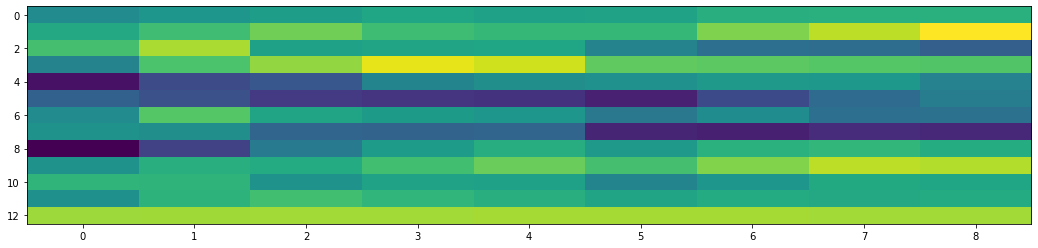

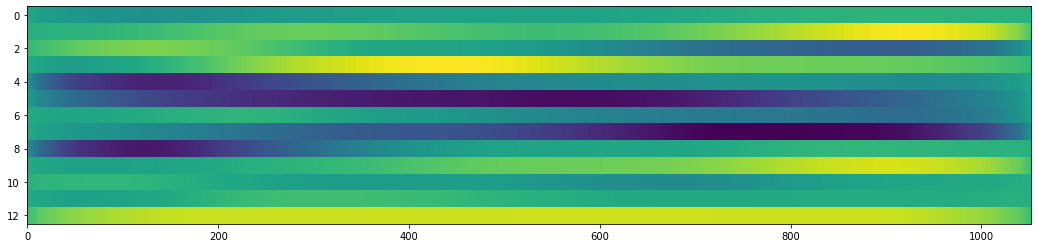

In [21]:
plot_spec(m[0].numpy())
plot_spec(mels[0].cpu().detach().numpy().T)
#print(mels.shape)
#print(aux.shape)

In [22]:
global step
step = 0

In [23]:
if not os.path.exists(STEP_PATH):
    np.save(STEP_PATH, step)
step = np.load(STEP_PATH)
step

array(3456)

In [24]:
def train(model, optimiser, epochs, batch_size, classes, seq_len, step, lr=1e-4) :
        
    for p in optimiser.param_groups : p['lr'] = lr
    criterion = nn.NLLLoss().cuda()
    
    for e in range(epochs) :

        trn_loader = DataLoader(dataset, collate_fn=collate, batch_size=batch_size, 
                                num_workers=0, shuffle=True, pin_memory=True)
    
        running_loss = 0.
        val_loss = 0.
        start = time.time()
        running_loss = 0.

        iters = len(trn_loader)

        for i, (x, m, p, y) in enumerate(trn_loader) :
            
            x, m, p, y = x.cuda(), m.cuda(), p.cuda(), y.cuda()

            y_hat = model(x, m, p)
            y_hat = y_hat.transpose(1, 2).unsqueeze(-1)
            y = y.unsqueeze(-1)
            loss = criterion(y_hat, y)
            
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()
            running_loss += loss.item()
            
            speed = (i + 1) / (time.time() - start)
            avg_loss = running_loss / (i + 1)
            
            step += 1
            k = step // 1000
            stream('Epoch: %i/%i -- Batch: %i/%i -- Loss: %.3f -- %.2f steps/sec -- Step: %ik ', 
                   (e + 1, epochs, i + 1, iters, avg_loss, speed, k))
        
        torch.save(model.state_dict(), MODEL_PATH)
        np.save(STEP_PATH, step)
        print(' <saved>')

In [25]:
current_thousand = -1
optimiser = optim.Adam(model.parameters())
print(optimiser)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)


## Generate Samples

In [26]:
def generate(samples=3, batched=True, target=11_000, overlap=550,plot_input=False,plot_output=True) :
    outputs = []
    k = step // 1000
    test_mels = [np.load(f'{DATA_PATH}mel/{id}.npy') for id in test_ids[:samples]]
    ground_truth = [np.load(f'{DATA_PATH}quant/{id}.npy') for id in test_ids[:samples]]
    test_pitch = [np.load(f'{DATA_PATH}pitch/{id}.npy') for id in test_ids[:samples]]
    for i, (gt, mel, pitch) in enumerate(zip(ground_truth, test_mels, test_pitch)) :
        #plot_spec(mel)
        print('\nGenerating: %i/%i' % (i+1, samples))
        gt = 2 * gt.astype(np.float32) / (2**bits - 1.) - 1.
        librosa.output.write_wav(f'{GEN_PATH}{k}k_steps_{i}_target.wav', gt, sr=sample_rate)
        if batched :
            save_str = f'{GEN_PATH}{k}k_steps_{i}_gen_batched_target{target}_overlap{overlap}.wav'
        else :    
            save_str = f'{GEN_PATH}{k}k_steps_{i}_gen_not_batched.wav'
        out = model.generate(mel, pitch, save_str, batched, target, overlap)
        print("")
        print(mel.shape)
        print(gt.shape)
        print(out.shape)
        outputs.append(out)
    
    for inpt,output in zip(ground_truth, outputs):
        if plot_input:
            plot(inpt)
        if plot_output:
            plot(output)

# Training 

In [ ]:
while True:
    try:
        if step // 1000 != current_thousand:
            current_thousand = step // 1000
            print(f'\nNow in {current_thousand}k steps\nGenerating outputs')
            generate(3,batched=True,plot_output=False)
        train(model, optimiser, epochs=10, batch_size=32, classes=2**bits, 
                seq_len=seq_len, step=step, lr=1e-4)
    except KeyboardInterrupt:
        break
    except:
        print("\nError")
        pass


Now in 3k steps
Generating outputs

Generating: 1/3
228000/229900 -- batch_size: 19 -- gen_rate: 6.0 kHz -- x_realtime: 0.3  
(13, 1819)
(212893,)
(220000,)

Generating: 2/3
48000/48400 -- batch_size: 4 -- gen_rate: 1.3 kHz -- x_realtime: 0.1  
(13, 358)
(41885,)
(46750,)

Generating: 3/3
228000/229900 -- batch_size: 19 -- gen_rate: 6.6 kHz -- x_realtime: 0.3  
(13, 1821)
(213149,)
(220000,)
Epoch: 1/10 -- Batch: 64/64 -- Loss: 3.282 -- 0.52 steps/sec -- Step: 3k  <saved>
Epoch: 2/10 -- Batch: 64/64 -- Loss: 3.228 -- 0.50 steps/sec -- Step: 3k  <saved>
Epoch: 3/10 -- Batch: 64/64 -- Loss: 3.196 -- 0.53 steps/sec -- Step: 3k  <saved>
Epoch: 4/10 -- Batch: 64/64 -- Loss: 3.233 -- 0.52 steps/sec -- Step: 3k  <saved>
Epoch: 5/10 -- Batch: 64/64 -- Loss: 3.191 -- 0.53 steps/sec -- Step: 3k  <saved>
Epoch: 6/10 -- Batch: 64/64 -- Loss: 3.183 -- 0.53 steps/sec -- Step: 3k  <saved>
Epoch: 7/10 -- Batch: 64/64 -- Loss: 3.174 -- 0.53 steps/sec -- Step: 3k  <saved>
Epoch: 8/10 -- Batch: 64/64 --

Epoch: 6/10 -- Batch: 64/64 -- Loss: 2.406 -- 0.54 steps/sec -- Step: 8k  <saved>
Epoch: 7/10 -- Batch: 64/64 -- Loss: 2.332 -- 0.53 steps/sec -- Step: 8k  <saved>
Epoch: 8/10 -- Batch: 64/64 -- Loss: 2.305 -- 0.53 steps/sec -- Step: 8k  <saved>
Epoch: 9/10 -- Batch: 64/64 -- Loss: 2.358 -- 0.54 steps/sec -- Step: 8k  <saved>
Epoch: 10/10 -- Batch: 64/64 -- Loss: 2.276 -- 0.54 steps/sec -- Step: 8k  <saved>

Now in 8k steps
Generating outputs

Generating: 1/3
228000/229900 -- batch_size: 19 -- gen_rate: 6.9 kHz -- x_realtime: 0.3  
(13, 1819)
(212893,)
(220000,)

Generating: 2/3
48000/48400 -- batch_size: 4 -- gen_rate: 1.5 kHz -- x_realtime: 0.1  
(13, 358)
(41885,)
(46750,)

Generating: 3/3
228000/229900 -- batch_size: 19 -- gen_rate: 7.0 kHz -- x_realtime: 0.3  
(13, 1821)
(213149,)
(220000,)
Epoch: 1/10 -- Batch: 64/64 -- Loss: 2.313 -- 0.54 steps/sec -- Step: 8k  <saved>
Epoch: 2/10 -- Batch: 64/64 -- Loss: 2.341 -- 0.54 steps/sec -- Step: 8k  <saved>
Epoch: 3/10 -- Batch: 64/64 -

228000/229900 -- batch_size: 19 -- gen_rate: 7.5 kHz -- x_realtime: 0.3  
(13, 1819)
(212893,)
(220000,)

Generating: 2/3
48000/48400 -- batch_size: 4 -- gen_rate: 1.6 kHz -- x_realtime: 0.1  
(13, 358)
(41885,)
(46750,)

Generating: 3/3
228000/229900 -- batch_size: 19 -- gen_rate: 7.2 kHz -- x_realtime: 0.3  
(13, 1821)
(213149,)
(220000,)
Epoch: 1/10 -- Batch: 64/64 -- Loss: 2.192 -- 0.58 steps/sec -- Step: 13k  <saved>
Epoch: 2/10 -- Batch: 64/64 -- Loss: 2.163 -- 0.57 steps/sec -- Step: 13k  <saved>
Epoch: 3/10 -- Batch: 64/64 -- Loss: 2.164 -- 0.57 steps/sec -- Step: 13k  <saved>
Epoch: 4/10 -- Batch: 64/64 -- Loss: 2.166 -- 0.57 steps/sec -- Step: 13k  <saved>
Epoch: 5/10 -- Batch: 64/64 -- Loss: 2.185 -- 0.57 steps/sec -- Step: 13k  <saved>
Epoch: 6/10 -- Batch: 64/64 -- Loss: 2.164 -- 0.56 steps/sec -- Step: 13k  <saved>
Epoch: 7/10 -- Batch: 64/64 -- Loss: 2.184 -- 0.57 steps/sec -- Step: 13k  <saved>
Epoch: 8/10 -- Batch: 64/64 -- Loss: 2.178 -- 0.57 steps/sec -- Step: 13k  <

Epoch: 5/10 -- Batch: 64/64 -- Loss: 2.010 -- 0.54 steps/sec -- Step: 17k  <saved>
Epoch: 6/10 -- Batch: 64/64 -- Loss: 1.994 -- 0.54 steps/sec -- Step: 17k  <saved>
Epoch: 7/10 -- Batch: 64/64 -- Loss: 1.997 -- 0.54 steps/sec -- Step: 17k  <saved>
Epoch: 8/10 -- Batch: 64/64 -- Loss: 1.998 -- 0.54 steps/sec -- Step: 18k  <saved>
Epoch: 9/10 -- Batch: 64/64 -- Loss: 2.323 -- 0.54 steps/sec -- Step: 18k  <saved>
Epoch: 10/10 -- Batch: 64/64 -- Loss: 2.149 -- 0.54 steps/sec -- Step: 18k  <saved>

Now in 18k steps
Generating outputs

Generating: 1/3
228000/229900 -- batch_size: 19 -- gen_rate: 7.4 kHz -- x_realtime: 0.3  
(13, 1819)
(212893,)
(220000,)

Generating: 2/3
48000/48400 -- batch_size: 4 -- gen_rate: 1.5 kHz -- x_realtime: 0.1  
(13, 358)
(41885,)
(46750,)

Generating: 3/3
228000/229900 -- batch_size: 19 -- gen_rate: 7.3 kHz -- x_realtime: 0.3  
(13, 1821)
(213149,)
(220000,)
Epoch: 1/10 -- Batch: 64/64 -- Loss: 2.034 -- 0.55 steps/sec -- Step: 18k  <saved>
Epoch: 2/10 -- Batch:

Epoch: 1/10 -- Batch: 64/64 -- Loss: 1.933 -- 0.54 steps/sec -- Step: 22k  <saved>
Epoch: 2/10 -- Batch: 64/64 -- Loss: 1.955 -- 0.54 steps/sec -- Step: 22k  <saved>
Epoch: 3/10 -- Batch: 64/64 -- Loss: 2.091 -- 0.54 steps/sec -- Step: 22k  <saved>
Epoch: 4/10 -- Batch: 64/64 -- Loss: 2.023 -- 0.54 steps/sec -- Step: 22k  <saved>
Epoch: 5/10 -- Batch: 64/64 -- Loss: 1.972 -- 0.54 steps/sec -- Step: 22k  <saved>
Epoch: 6/10 -- Batch: 64/64 -- Loss: 1.928 -- 0.54 steps/sec -- Step: 22k  <saved>
Epoch: 7/10 -- Batch: 64/64 -- Loss: 2.031 -- 0.55 steps/sec -- Step: 22k  <saved>
Epoch: 8/10 -- Batch: 64/64 -- Loss: 1.874 -- 0.54 steps/sec -- Step: 22k  <saved>
Epoch: 9/10 -- Batch: 64/64 -- Loss: 1.916 -- 0.55 steps/sec -- Step: 23k  <saved>
Epoch: 10/10 -- Batch: 64/64 -- Loss: 1.930 -- 0.55 steps/sec -- Step: 23k  <saved>

Now in 23k steps
Generating outputs

Generating: 1/3
228000/229900 -- batch_size: 19 -- gen_rate: 7.1 kHz -- x_realtime: 0.3  
(13, 1819)
(212893,)
(220000,)

Generatin

228000/229900 -- batch_size: 19 -- gen_rate: 7.3 kHz -- x_realtime: 0.3  
(13, 1819)
(212893,)
(220000,)

Generating: 2/3
48000/48400 -- batch_size: 4 -- gen_rate: 1.6 kHz -- x_realtime: 0.1  
(13, 358)
(41885,)
(46750,)

Generating: 3/3
228000/229900 -- batch_size: 19 -- gen_rate: 7.4 kHz -- x_realtime: 0.3  
(13, 1821)
(213149,)
(220000,)
Epoch: 1/10 -- Batch: 64/64 -- Loss: 1.911 -- 0.55 steps/sec -- Step: 27k  <saved>
Epoch: 2/10 -- Batch: 64/64 -- Loss: 1.943 -- 0.54 steps/sec -- Step: 27k  <saved>
Epoch: 3/10 -- Batch: 64/64 -- Loss: 1.880 -- 0.54 steps/sec -- Step: 27k  <saved>
Epoch: 4/10 -- Batch: 64/64 -- Loss: 1.830 -- 0.55 steps/sec -- Step: 27k  <saved>
Epoch: 5/10 -- Batch: 64/64 -- Loss: 1.941 -- 0.55 steps/sec -- Step: 27k  <saved>
Epoch: 6/10 -- Batch: 64/64 -- Loss: 1.868 -- 0.55 steps/sec -- Step: 27k  <saved>
Epoch: 7/10 -- Batch: 64/64 -- Loss: 1.928 -- 0.55 steps/sec -- Step: 27k  <saved>
Epoch: 8/10 -- Batch: 64/64 -- Loss: 1.873 -- 0.55 steps/sec -- Step: 27k  <

Epoch: 6/10 -- Batch: 64/64 -- Loss: 1.810 -- 0.55 steps/sec -- Step: 32k  <saved>
Epoch: 7/10 -- Batch: 64/64 -- Loss: 1.823 -- 0.55 steps/sec -- Step: 32k  <saved>
Epoch: 8/10 -- Batch: 64/64 -- Loss: 1.838 -- 0.55 steps/sec -- Step: 32k  <saved>
Epoch: 9/10 -- Batch: 64/64 -- Loss: 1.912 -- 0.55 steps/sec -- Step: 32k  <saved>
Epoch: 10/10 -- Batch: 64/64 -- Loss: 2.008 -- 0.55 steps/sec -- Step: 32k  <saved>

Now in 32k steps
Generating outputs

Generating: 1/3
228000/229900 -- batch_size: 19 -- gen_rate: 7.2 kHz -- x_realtime: 0.3  
(13, 1819)
(212893,)
(220000,)

Generating: 2/3
48000/48400 -- batch_size: 4 -- gen_rate: 1.6 kHz -- x_realtime: 0.1  
(13, 358)
(41885,)
(46750,)

Generating: 3/3
228000/229900 -- batch_size: 19 -- gen_rate: 7.3 kHz -- x_realtime: 0.3  
(13, 1821)
(213149,)
(220000,)
Epoch: 1/10 -- Batch: 64/64 -- Loss: 1.768 -- 0.55 steps/sec -- Step: 32k  <saved>
Epoch: 2/10 -- Batch: 64/64 -- Loss: 1.803 -- 0.54 steps/sec -- Step: 32k  <saved>
Epoch: 3/10 -- Batch:

Epoch: 7/10 -- Batch: 64/64 -- Loss: 1.992 -- 0.55 steps/sec -- Step: 37k  <saved>
Epoch: 8/10 -- Batch: 64/64 -- Loss: 1.788 -- 0.55 steps/sec -- Step: 37k  <saved>
Epoch: 9/10 -- Batch: 64/64 -- Loss: 1.781 -- 0.54 steps/sec -- Step: 37k  <saved>
Epoch: 10/10 -- Batch: 64/64 -- Loss: 1.879 -- 0.55 steps/sec -- Step: 37k  <saved>

Now in 37k steps
Generating outputs

Generating: 1/3
228000/229900 -- batch_size: 19 -- gen_rate: 7.4 kHz -- x_realtime: 0.3  
(13, 1819)
(212893,)
(220000,)

Generating: 2/3
48000/48400 -- batch_size: 4 -- gen_rate: 1.5 kHz -- x_realtime: 0.1  
(13, 358)
(41885,)
(46750,)

Generating: 3/3
228000/229900 -- batch_size: 19 -- gen_rate: 7.3 kHz -- x_realtime: 0.3  
(13, 1821)
(213149,)
(220000,)
Epoch: 1/10 -- Batch: 64/64 -- Loss: 1.834 -- 0.55 steps/sec -- Step: 37k  <saved>
Epoch: 2/10 -- Batch: 64/64 -- Loss: 1.817 -- 0.53 steps/sec -- Step: 37k  <saved>
Epoch: 3/10 -- Batch: 64/64 -- Loss: 1.873 -- 0.54 steps/sec -- Step: 37k  <saved>
Epoch: 4/10 -- Batch: